This is the overall code to:
    1) Take the broadband r image, convert to nanomaggies and AB mags
    2) Add in background
    3) Produce an error image according to Poisson statistics (+ background + readnoise)
    4) Produce an error spectrum according to the same statistics (at each wavelength)
    5) Prepare to entre into ppxf according to the MaNGA specs

In [5]:
import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches
from astropy.io import fits


from astropy.cosmology import WMAP9 as cosmo

import pyfits
import matplotlib.pyplot as plt

import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches

import sys 

sys.path.append('/usr/local/lib/python2.7/site-packages/ppxf')
sys.path

from __future__ import print_function

from astropy.io import fits
import numpy as np
import glob
from time import clock
from os import path

from ppxf import ppxf
import ppxf_util as util
plt.clf()




In [6]:
'''This code block reads in the broadband images and then will open the broadband extension,
...
'''
a=pyfits.open('q0.5_fg0.3_allrx10/broadband_200.fits')


#So the shape of thie CAMERA(#)-BROADBAND is 5x300x300 where each 
#of the first dimension is the SDSS filter (ugriz) [we want 2]

'''Next try to extract the broadband filters'''
''''CAMERA[N]-BROADBAND', which are data cubes of dimension 
[300 pixels] x [300 pixels] x [5 sdss filters]  and contain 
the actual images
Units are surface brightness in units of: 
IMUNIT  = 'W/m/m^2/sr'         / Pixel quantity is surface brightness           
UNITCONV= 9.45238524920703E-35 / [m^2/(kpc^2)]

Spatially, each pixel is 0.5 kpc for the early stage and 0.1666 kpc for the late stage'''

plt.clf()

camera_data = a['CAMERA0-BROADBAND'].data
camera_header = a['CAMERA0-BROADBAND'].header



xs = np.linspace(0,shape(camera_data[0])[0]-1,shape(camera_data[0])[0])
xs_kpc = [0.1666*x for x in xs]

'''First make a plot of all the different filters side by side'''
fig=plt.figure()
ax0=fig.add_subplot(1,5,1)
ax0.imshow(camera_data[0], vmin=0, vmax=15)
ax0.set_title('u band')
plt.axis('off')

ax1=fig.add_subplot(1,5,2)
ax1.imshow(camera_data[1], vmin=0, vmax=15)
ax1.set_title('g band')
plt.axis('off')

ax2=fig.add_subplot(1,5,3)
ax2.imshow(camera_data[2], vmin=0, vmax=15)
ax2.set_title('r band')
plt.axis('off')

ax3=fig.add_subplot(1,5,4)
im3=ax3.imshow(camera_data[3], vmin=0, vmax=15)
ax3.set_title('i band')
#plt.colorbar(im3, orientation='horizontal')
plt.axis('off')

ax4=fig.add_subplot(1,5,5)
ax4.imshow(camera_data[4], vmin=0, vmax=15)
ax4.set_title('z band')
plt.axis('off')
savefig('../MaNGA_papers/Paper_I/all_filters.pdf')




In [70]:
'''Now I have to convert the units of LAURAS sims into nanomaggies and AB mags (mags of DR7 and DR13)
'''
#first, go from specific intensity (because we have per steradian) to 
#janskies (W/Hz/m^2)
c = 299792.458*1000#to get into m/s

#this 1.35e-6 comes from the arcsin(R_sky/Distance to object)
#the answer needs to be in radians

#J=10^-26 W/m^2/Hz, so units of flux density
#reference site: http://www.cv.nrao.edu/course/astr534/Brightness.html
#We need to go from a spectral brightness (I_nu) which is in m units
#To a flux density (S_nu) which is in units of Janskies (W/m^2/Hz)

#So you need to multiply the Fν by c / λ^2 to convert it into Fλ. 
#But we are not done yet! Recalling from above, the units of Fλ 
#are not an energy density. You need to get another factor of λ 
#in there to make the units work out to be energy density: 
#calculate λFλ to get units of ergs/s/cm^2.

#1.35e-6 comes from: sin^-1(pixelscale=0.166666#kpc/pix/ comoving distance in kpc)
pixelscale=0.166666#kpc/pix/
d_a = cosmo.angular_diameter_distance(0.03).value#, **fidcosmo)
d_co = cosmo.comoving_distance(0.03).value
d_lum = cosmo.luminosity_distance(0.03).value 
print("Angluar-diameter distance to z=0.03 is", 1000*(d_a), 'kpc')
print("Comoving distance to z=0.03 is", 1000*((d_co)), 'kpc')
print("Luminosity distance to z=0.03 is", 1000*((d_lum)), 'kpc')



#here's a good review of all the different distances
#http://www.astro.ufl.edu/~guzman/ast7939/projects/project01.html


Janskies=np.array(10**(26)*camera_data[2]*(pixelscale/(1000*d_lum))**2*np.pi*((6185.2*10**(-10))**2/c), dtype='>f4')
#A Jansky is 10−26 watts per square metre per hertz.



nanomaggy=Janskies/(3.631*10**(-6))




plt.imshow(np.flipud(nanomaggy),vmin=0, vmax=2)
plt.ylabel(r'kpc [0.1666/pix]')
plt.xlabel(r'kpc [0.1666/pix]')
cb1=plt.colorbar()
cb1.set_label('r-band Flux Density [nanomaggies]')
savefig('pyplots_q0.5_fg0.3_allrx10/200_CAMERA0_2_nanomaggy.pdf')

'''Now convert into the correct background:)'''

#nanomaggies and stuff: (Finkbeiner et al. 2004)

'''The average background and std as well as the readnoise and gain
are from another code of mine:
    SDSS_noise_imaging/SDSS_r_imaging.ipynb'''
    

sky_resids_mine=np.random.normal(0.01955593,0.0042225,shape(nanomaggy))
poisson_plus = np.sqrt((np.flipud(nanomaggy)+ 0.004701377)/1367.29546)+sky_resids_mine
poisson_plus_nanomags = poisson_plus*1367.29546
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)

im0=ax0.imshow(np.flipud(nanomaggy), vmin=0, vmax=5)
ax0.set_title(r'Before')
plt.colorbar(im0,label=r'Flux [Nanomaggies]', orientation='horizontal')

ax1=fig.add_subplot(1,2,2)


im1=ax1.imshow(np.flipud(nanomaggy)+1367.29546*sky_resids_mine**2, vmin=0, vmax=5)
ax1.set_title(r'After')
plt.colorbar(im1,label=r'Flux [Nanomaggies]', orientation='horizontal')
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/background_added.pdf')


fig=plt.figure()
ax1=fig.add_subplot(1,1,1)


im1=ax1.imshow(poisson_plus, vmin=0, vmax=0.1)
ax1.set_title(r'Error Image')
plt.colorbar(im1,label=r'Flux [Counts]', orientation='vertical')
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/error_fake.pdf')


mag=22.5-2.5*np.log10(nanomaggy)

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)


im1=ax1.imshow(np.flipud(mag), cmap='afmhot_r', vmin=0, vmax=40)
#ax1.set_title(r'Magnitude Image')
cb1=plt.colorbar(im1,label=r'Flux [m$_{\mathrm{AB}}$]', orientation='vertical')

cb1.ax.invert_yaxis()
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/magnitude.pdf')


'''write it out so that GALFIT can use it'''
outfile = 'q0.5_fg0.3_allrx10/test_out.fits'

hdu = fits.PrimaryHDU(np.flipud(nanomaggy)+1367.29546*sky_resids_mine**2)
hdu.writeto(outfile, clobber=True)

outfile = 'q0.5_fg0.3_allrx10/test_out_error.fits'

hdu = fits.PrimaryHDU(poisson_plus)
hdu.writeto(outfile, clobber=True)



Angluar-diameter distance to z=0.03 is 125146.00822706954 kpc
Comoving distance to z=0.03 is 128900.38847388163 kpc
Luminosity distance to z=0.03 is 132767.4001280981 kpc


kernel 2.488741675955623


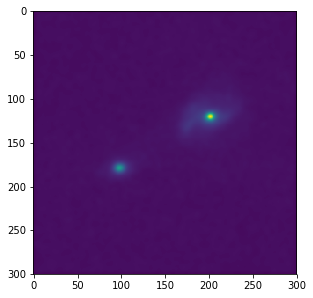

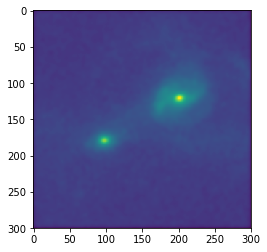

In [92]:
'''Now, I need to convolve them with the Gaussian Kernel that represents the size of the PSF'''
#PSF = 1.61 arcsec
plt.clf()

from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

kpc_arcmin=cosmo.kpc_proper_per_arcmin(0.03)#insert the redshift to get the kpc/arcmin scaling

sigma=1.61/2.355#apparently the preimage sigma is not large :)
##kpc/pix is the pixelscale
##conversion factor is kpc/"
#1.61 is the FWHM in arcsec of the psf
#pixelscale is kpc/pix
kernel_sigma_pix=(sigma*(kpc_arcmin.value/60))/pixelscale
print('kernel', kernel_sigma_pix)

gaussian_2D_kernel = Gaussian2DKernel(kernel_sigma_pix)#standard deviation in pixels



#result = convolve(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
result = convolve(np.flipud(nanomaggy)+1367.29546*sky_resids_mine**2, gaussian_2D_kernel)
result_error = convolve((poisson_plus_nanomags), gaussian_2D_kernel)
#result_2 = convolve_fft(np.sum(CAMERA0.data[:,:,:],axis=0), gaussian_2D_kernel)
result_counts = convolve((np.flipud(nanomaggy)+1367.29546*sky_resids_mine**2), gaussian_2D_kernel)
result_counts_error = convolve((poisson_plus), gaussian_2D_kernel)
#poisson plus is the error on counts
plt.imshow(result)
plt.show()
plt.imshow(result_error)
plt.show()


fig=plt.figure()

ax3=fig.add_subplot(1,3,1)
im3=ax3.imshow((nanomaggy), vmin=0, vmax=5, cmap='viridis_r',interpolation='none',origin='lower')
ax3.set_title(r'')
plt.colorbar(im3, orientation='horizontal')
plt.axis('off')

ax0=fig.add_subplot(1,3,2)



im0=ax0.imshow((nanomaggy)+1367.29546*sky_resids_mine**2, vmin=0, vmax=5, cmap='viridis_r',interpolation='none',origin='lower')
ax0.set_title(r'Background Added')
plt.colorbar(im0,label=r'Flux [Nanomaggies]', orientation='horizontal')
plt.axis('off')
ax1=fig.add_subplot(1,3,3)


im1=ax1.imshow(np.flipud(result), vmin=0, vmax=5, cmap='viridis_r',interpolation='none',origin='lower')
ax1.set_title(r'PSF Applied')
plt.colorbar(im1, orientation='horizontal')
#plt.tight_layout()
plt.axis('off')
savefig('../MaNGA_papers/Paper_I/background_added_convolved.pdf')


outfile = 'out_convolved.fits'
hdu = fits.PrimaryHDU(result)
hdu.writeto(outfile, clobber=True)

outfile = 'out_sigma_convolved.fits'
hdu = fits.PrimaryHDU(result_error)
hdu.writeto(outfile, clobber=True)

In [93]:
import subprocess
#subprocess.call("cd GALFIT_folder/", shell=True)
subprocess.call("galfit galfit.feedme", shell=True)



0

Effective Radius in pixels 56.4946 +/- 1.0401


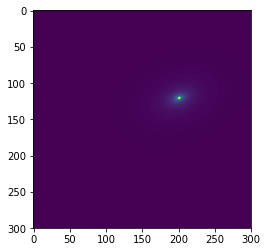

In [94]:
'''Now open the galfit result and get the effective radius '''

plt.clf()
output='imgblock_convolved.fits'
out=pyfits.open(output)
#2 is model
#3 is residual map

print('Effective Radius in pixels',out[2].header['1_RE'])
#also, galfit.xx is the final output
#fit.log has the chi squared values and stuff

fig=plt.figure()

plt.imshow(out[2].data)
plt.show()


galfit_input=out[1].data
galfit_model=out[2].data
galfit_resid=out[3].data
fig=plt.figure()

ax1 = fig.add_subplot(131, aspect='equal')
ax1.set_title('Data')

pixelscale=0.166666#kpc/pix
#spacing=((kpc_arcmin.value/60))/pixelscale
#axis is 100x100 pixels
ticklocs=[0,25,50,75,100]

v = np.linspace(0, 0.01, 2, endpoint=True)

kpc=[round(pixelscale*(x-50),1) for x in ticklocs]

im1=ax1.imshow(galfit_input[75:175,150:250], cmap='viridis_r', vmin=0, vmax=7)
ax1.set_xticks(ticklocs)
ax1.set_xticklabels(kpc)
ax1.set_yticks(ticklocs)
ax1.set_yticklabels(kpc)
plt.colorbar(im1, orientation='horizontal')


ax2 = fig.add_subplot(132, aspect='equal')
ax2.set_title('Galfit Model')
im2=ax2.imshow(galfit_model[75:175,150:250], cmap='viridis_r', vmin=0, vmax=7)
ax2.set_xticks(ticklocs)
ax2.set_xticklabels(kpc)
ax2.set_yticks(ticklocs)
ax2.set_yticklabels(kpc)
plt.colorbar(im2, orientation='horizontal', label=r'Flux [nanomaggies]')


ax3 = fig.add_subplot(133, aspect='equal')
ax3.set_title('Residuals')
im3=ax3.imshow(galfit_resid[75:175,150:250], cmap='viridis_r', vmin=-1, vmax=1)
v=np.linspace(-1,1,3)
ax3.set_xticks(ticklocs)
ax3.set_xticklabels(kpc)
ax3.set_yticks(ticklocs)
ax3.set_yticklabels(kpc)
plt.colorbar(im3, orientation='horizontal', ticks=v)
plt.tight_layout()
savefig('../MaNGA_papers/Paper_I/Galfit_ex.pdf')


In [34]:
'''Nice, now its time to think about convolving the spectrum itself'''